In [1]:
#if not already installed
!python3 -m pip install h5py sklearn

In [6]:
#imports
import os
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import functools
import matplotlib.pyplot as plt
import math
import scipy

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold

import sys
sys.path.insert(1, '../') #make parent folder visible
from transformer import CosineWithRestarts

In [46]:
embeddings_path = "embedding_binaries/"

In [8]:
BATCH_SIZE = 128
EPOCHS = 10

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


# Select A Dataset
* Datasets are h5py binary files
* Each contains an array with the Transformer embeddings for each molecule
* And additional arrays with SMILES strings, binding labels, etc.

In [47]:
#how many epochs was the transformer trained before generating embeddings?
epoch_id = "2"

assays = os.listdir(embeddings_path)
if epoch_id is not None:
    #assays = [assay for assay in assays if assay.split(".")[0].split("_")[-1] == str(epoch_id)]
    assays = [assay for assay in assays if assay.split(".")[0].split("_")[-1] == str(epoch_id)]
print(assays)

['hiv1_protease_2.hdf5']


In [11]:
#Set assay_idx to the index of the desired h5py file in the above list
assay_idx = 0
assay_path = os.path.join(embeddings_path, assays[assay_idx])
print(assay_path)

embeddings/hiv1_protease_2.hdf5


# Load and Prepare Data

In [12]:
#load dataset
assay = h5py.File(assay_path, 'r')

In [13]:
embeddings = assay['embeddings'] #embeddings array
labels_result = assay['result'] #numeric assay result
labels_binding = assay['binding'] #0 or 1 ("not binding" / "binding")
smiles_enc = assay['smiles'] #smiles strings

In [14]:
num_iters = int(math.ceil(embeddings.shape[0] / BATCH_SIZE))
print(F'{embeddings.shape[0]} molecules')
print(F'{num_iters} training batches')

7462 molecules
59 training batches


In [15]:
binding = labels_binding[:]

In [16]:
binding.sum() #how many "binding" molecules

2159

In [17]:
def undersample(idxs, labels, ratio=1):
    no_bind_idxs = idxs[labels[idxs]==0]
    bind_idxs = idxs[labels[idxs]==1]
    min_len = min(len(bind_idxs), len(no_bind_idxs)) * ratio
    
    np.random.shuffle(no_bind_idxs)
    np.random.shuffle(bind_idxs)
    
    no_bind_idxs = no_bind_idxs[:min_len]
    bind_idxs = bind_idxs[:min_len]
    
    idxs = np.concatenate((no_bind_idxs, bind_idxs))
    np.random.shuffle(idxs)
    
    return idxs

In [18]:
#increase ratio to include more "non-binding" samples
idxs = undersample(np.arange(len(binding)), binding, ratio=1)
idxs.shape

(4318,)

In [19]:
def reduce_data(data, idxs):
    return [torch.tensor(np.stack([d[idx] for idx in idxs])) for d in data]

In [20]:
#create pytorch tensors from the arrays
e, sm, y = reduce_data([embeddings, smiles_enc, binding], idxs)
print(e.shape, sm.shape, y.shape)

torch.Size([4318, 256, 512]) torch.Size([4318, 256]) torch.Size([4318])


In [21]:
#generate random projections of smiles strings (equivalent to the random projections produced by an untrained transformer)
#this serves the same purpose as classifying SMILES strings directly
#the hard-coded embedding size here should be adjusted to match trained embedding size (printed above)
random_projection = (torch.randn(98,512))
s = random_projection[(sm * 98).long().flatten(),:].view(-1, 256, 512)
print(s.shape, s.type())

torch.Size([4318, 256, 512]) torch.FloatTensor


In [22]:
#count of batches in a training epoch
PRINT_ITERS = int(math.ceil(y.shape[0]*9//10 / BATCH_SIZE))
PRINT_ITERS

31

# Create Classifier and Helper Functions for Training

### Batch Generator
* will randomly iterate over the arrays

In [23]:
def get_batch_iter(arrays, batch_size, idxs, device):
    device_tensor = functools.partial(torch.tensor, device=device)
    array_len = idxs.shape[0]
    p = np.random.permutation(idxs)
    for i in range(0, array_len, batch_size):
        indexes = p[i:min(i+batch_size, array_len)]
        #indexes.sort()
        batches = [arr[list(indexes)] for arr in arrays]
        
        p2 = np.random.permutation(len(indexes))
        batches = [batch[p2] for batch in batches]
        
        yield tuple(map(device_tensor, batches))

### Classifier
* Here a simple, fully connected network is used
* This can be replaced with a different or more complex classifier

In [24]:
class FC(nn.Module):
    def __init__(self, input_features=256*512, activation=F.relu):
        super(FC, self).__init__()
        self.act = activation
        self.input_size = input_features
        
        self.dim1 = 500
        self.dim2 = 100
        
        self.fc1 = nn.Linear(self.input_size, self.dim1)
        self.fc2 = nn.Linear(self.dim1, self.dim1)
        self.dropout = nn.Dropout(p=0.8)
        
        self.fc3 = nn.Linear(self.dim1, self.dim2)
        self.fc4 = nn.Linear(self.dim2, 2)
        
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = self.act(self.fc1(x))
        x = self.fc2(x)
        x = self.dropout(self.act(x))
        
        x_int = self.fc3(x)
        x = self.fc4(self.act(x_int))
        
        return x, x_int

### Helper Functions

In [25]:
def print_update(epoch=0, iters=0, mode="TRAIN", loss=0, acc=0, c0=0, c1=0):
    print("{mode:>5}- E:{epoch:2d}- I:{iters:4d} loss:{loss:6.3f}, acc:{acc:6.2f}%, c0:{c0:5.1f}%, c1:{c1:5.1f}%".format(epoch=epoch, iters=iters, mode=mode, loss=loss, acc=acc*100, c0=c0*100, c1=c1*100))

In [26]:
def calc_accuracy(preds, labels):
    pred_idx = torch.max(preds, 1)[1]
    return (pred_idx == labels).to(torch.float).mean().item()

In [27]:
def calc_class_accuracies(preds, labels):
    class_accs = []
    for i in range(int(labels.max().item()) + 1):
        class_idxs = torch.nonzero(labels==i)
        class_labels = labels[class_idxs]
        class_preds = preds[class_idxs]
        class_pred_idx = torch.max(class_preds, -1)[1]
        class_acc = (class_pred_idx == class_labels).to(torch.float).mean().item()
        class_accs.append(class_acc)
    return class_accs

In [28]:
def train_epoch(epoch, x, y, idxs):
    model.train()
    running_loss = 0
    running_preds_cls, running_binding = [], []
    optimizer.zero_grad()
    for i, (embedding, label_binding) in enumerate(get_batch_iter([x, y],  BATCH_SIZE, idxs, DEVICE)):
        label_binding = label_binding.to(torch.long)
        preds_cls, _ = model(embedding)
        
        loss = 0
        
        loss_cls = criterion(preds_cls, label_binding)
        loss += loss_cls
        running_preds_cls.append(preds_cls)
        running_binding.append(label_binding)
            
        loss.backward()
        
        optimizer.step()
        sched.step()
        optimizer.zero_grad()

        running_loss += loss.item()
        
        if (i+1) % PRINT_ITERS == 0:
            acc, class_accs = 0, [0, 0]
            
            running_preds_cls = torch.cat(running_preds_cls)
            running_binding = torch.cat(running_binding)
            acc = calc_accuracy(running_preds_cls, running_binding)
            class_accs = calc_class_accuracies(running_preds_cls, running_binding)
            
            print_update(epoch=epoch, iters=i+1, loss=running_loss / PRINT_ITERS, acc=acc, c0=class_accs[0], c1=class_accs[1])
            
            running_loss = 0
            running_preds_cls, running_binding = [], []

In [29]:
def test_epoch(epoch, x, y, idxs):
    model.eval()
    with torch.no_grad():
        all_preds_cls, all_binding, all_preds_int = [], [], []
        for i, (embedding, label_binding) in enumerate(get_batch_iter([x, y],  BATCH_SIZE, idxs, DEVICE)):
            label_binding = label_binding.to(torch.long)
            preds_cls, preds_int = model(embedding)
            all_preds_cls.append(preds_cls)
            all_binding.append(label_binding)
            all_preds_int.append(preds_int)
            
        all_preds_cls = torch.cat(all_preds_cls)
        all_binding = torch.cat(all_binding)
        all_preds_int = torch.cat(all_preds_int)
        
        loss = 0
        
        loss_cls = criterion(all_preds_cls, all_binding).item()
        loss += loss_cls
        
        acc, class_accs = 0, [0, 0]
        
        acc = calc_accuracy(all_preds_cls, all_binding)
        class_accs = calc_class_accuracies(all_preds_cls, all_binding)
        
    print_update(mode="TEST", epoch=epoch, iters=i+1, loss=loss, acc=acc, c0=class_accs[0], c1=class_accs[1])
    
    return loss, acc, class_accs, all_preds_cls, all_preds_int, all_binding

In [30]:
min_test_idxs = int(len(idxs)/10)

# Training Loop
* Outer loop runs once for each embedding type (trained vs untrained)
* Uses cross-validation
* Training metrics are printed sequentially
* Predictions are saved in cv_accs, cv_labs, cv_preds for results calculations

In [31]:
cv = StratifiedKFold(n_splits=10)
comp_accs, comp_labs, comp_preds = [], [], []
for x in [e, s]: #embedding (e), untrained embedding (s)
    cv_accs, cv_labs, cv_preds = [], [], []
    for i, (train_idxs, test_idxs) in enumerate(cv.split(x, y)):
        model = FC(input_features=np.prod(x.shape[1:])).to(DEVICE)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
        sched = CosineWithRestarts(optimizer, T_max=num_iters)
        
        test_losses, test_accs = [], []
        for epoch in range(1, EPOCHS + 1):
            train_epoch(epoch, x, y, train_idxs)
            loss, acc, class_accs, all_preds, all_int, all_labels = test_epoch(epoch, x, y, test_idxs)
            test_losses.append(loss)
            test_accs.append(acc)
            if epoch > 2:
                comp = np.array(test_losses)
                comp = (comp[1:] - comp[:-1]) <= 0
                if not np.any(comp[-2:]):
                    test_accs[-1] = test_accs[-3]
                    break
        cv_accs.append(test_accs[-1])
        
        loss, accuracy, class_accs, all_preds, all_int, all_labels = test_epoch(0, x, y, test_idxs)
        all_labels, all_preds = all_labels.cpu().numpy(), all_preds.cpu().numpy()
        all_preds = F.softmax(torch.tensor(all_preds), dim=1).numpy()[:,1]
        cv_labs.append(all_labels[:min_test_idxs])
        cv_preds.append(all_preds[:min_test_idxs])
        
    print(np.array(cv_accs))
    comp_accs.append(np.array(cv_accs))
    comp_labs.append(np.array(cv_labs))
    comp_preds.append(np.array(cv_preds))

comp_accs = np.array(comp_accs)
comp_labs = np.array(comp_labs)
comp_preds = np.array(comp_preds)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


TRAIN- E: 1- I:  31 loss: 0.179, acc: 92.82%, c0: 90.4%, c1: 95.2%
 TEST- E: 1- I:   4 loss: 0.029, acc: 99.31%, c0: 99.5%, c1: 99.1%
TRAIN- E: 2- I:  31 loss: 0.034, acc: 99.18%, c0: 99.1%, c1: 99.3%
 TEST- E: 2- I:   4 loss: 0.025, acc: 99.31%, c0: 99.5%, c1: 99.1%
TRAIN- E: 3- I:  31 loss: 0.017, acc: 99.54%, c0: 99.5%, c1: 99.6%
 TEST- E: 3- I:   4 loss: 0.027, acc: 99.07%, c0: 99.1%, c1: 99.1%
TRAIN- E: 4- I:  31 loss: 0.004, acc: 99.92%, c0: 99.9%, c1: 99.9%
 TEST- E: 4- I:   4 loss: 0.048, acc: 98.84%, c0: 99.1%, c1: 98.6%
 TEST- E: 0- I:   4 loss: 0.048, acc: 98.84%, c0: 99.1%, c1: 98.6%
TRAIN- E: 1- I:  31 loss: 0.190, acc: 92.15%, c0: 92.5%, c1: 91.8%
 TEST- E: 1- I:   4 loss: 0.066, acc: 98.84%, c0: 98.6%, c1: 99.1%
TRAIN- E: 2- I:  31 loss: 0.023, acc: 99.18%, c0: 99.3%, c1: 99.0%
 TEST- E: 2- I:   4 loss: 0.075, acc: 98.38%, c0: 97.2%, c1: 99.5%
TRAIN- E: 3- I:  31 loss: 0.018, acc: 99.64%, c0: 99.5%, c1: 99.8%
 TEST- E: 3- I:   4 loss: 0.113, acc: 97.92%, c0: 97.7%, c1: 9

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


TRAIN- E: 1- I:  31 loss: 2.200, acc: 73.06%, c0: 73.1%, c1: 73.0%
 TEST- E: 1- I:   4 loss: 0.341, acc: 86.57%, c0: 85.2%, c1: 88.0%
TRAIN- E: 2- I:  31 loss: 0.439, acc: 84.59%, c0: 82.6%, c1: 86.6%
 TEST- E: 2- I:   4 loss: 0.307, acc: 87.50%, c0: 84.3%, c1: 90.7%
TRAIN- E: 3- I:  31 loss: 0.377, acc: 85.25%, c0: 83.2%, c1: 87.3%
 TEST- E: 3- I:   4 loss: 0.284, acc: 88.66%, c0: 91.2%, c1: 86.1%
TRAIN- E: 4- I:  31 loss: 0.304, acc: 88.21%, c0: 85.6%, c1: 90.8%
 TEST- E: 4- I:   4 loss: 0.265, acc: 87.27%, c0: 86.1%, c1: 88.4%
TRAIN- E: 5- I:  31 loss: 0.314, acc: 87.78%, c0: 87.0%, c1: 88.5%
 TEST- E: 5- I:   4 loss: 0.266, acc: 88.89%, c0: 84.3%, c1: 93.5%
TRAIN- E: 6- I:  31 loss: 0.241, acc: 91.10%, c0: 90.1%, c1: 92.1%
 TEST- E: 6- I:   4 loss: 0.368, acc: 81.48%, c0: 98.6%, c1: 64.4%
 TEST- E: 0- I:   4 loss: 0.368, acc: 81.48%, c0: 98.6%, c1: 64.4%
TRAIN- E: 1- I:  31 loss: 2.938, acc: 71.59%, c0: 72.1%, c1: 71.1%
 TEST- E: 1- I:   4 loss: 0.316, acc: 86.81%, c0: 75.9%, c1: 9

TRAIN- E: 7- I:  31 loss: 0.219, acc: 91.79%, c0: 91.2%, c1: 92.4%
 TEST- E: 7- I:   4 loss: 0.179, acc: 93.98%, c0: 94.9%, c1: 93.1%
TRAIN- E: 8- I:  31 loss: 0.180, acc: 93.34%, c0: 91.8%, c1: 94.9%
 TEST- E: 8- I:   4 loss: 0.188, acc: 93.29%, c0: 94.9%, c1: 91.7%
TRAIN- E: 9- I:  31 loss: 0.141, acc: 95.01%, c0: 93.5%, c1: 96.5%
 TEST- E: 9- I:   4 loss: 0.150, acc: 95.37%, c0: 95.8%, c1: 94.9%
TRAIN- E:10- I:  31 loss: 0.131, acc: 94.57%, c0: 94.1%, c1: 95.0%
 TEST- E:10- I:   4 loss: 0.179, acc: 94.21%, c0: 97.7%, c1: 90.7%
 TEST- E: 0- I:   4 loss: 0.179, acc: 94.21%, c0: 97.7%, c1: 90.7%
TRAIN- E: 1- I:  31 loss: 1.781, acc: 74.70%, c0: 72.6%, c1: 76.8%
 TEST- E: 1- I:   4 loss: 0.393, acc: 88.19%, c0: 84.3%, c1: 92.1%
TRAIN- E: 2- I:  31 loss: 0.445, acc: 84.25%, c0: 82.0%, c1: 86.5%
 TEST- E: 2- I:   4 loss: 0.348, acc: 88.43%, c0: 84.3%, c1: 92.6%
TRAIN- E: 3- I:  31 loss: 0.380, acc: 85.46%, c0: 82.8%, c1: 88.1%
 TEST- E: 3- I:   4 loss: 0.304, acc: 89.58%, c0: 86.6%, c1: 9

In [35]:
#save softmax predictions of each output neuron
#for each CV test fold, for each embedding type
#also save accuracy and labels for convenience

#this filename needs to be changed manually for the dataset used
np.savez("result_arrays/hiv1_protease.npz", accs=comp_accs, labs=comp_labs, preds=comp_preds)

# Calculate and Plot AUC
* This should be done after the notebook is run (and predictions are saved) for each dataset

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score, auc

In [33]:
plt.style.use('ggplot')

In [35]:
#list all result files
result_files = os.listdir('result_arrays/')
result_files = [x for x in result_files if x.endswith(".npz")]
print(result_files)

['1053197.npz', 'hiv1_protease.npz', '652067.npz']


In [36]:
keep_idxs = [1, 2, 0] #which idxs from the above list to include

result_files = [result_files[i] for i in keep_idxs]
#result_names = [x.strip('.npz') for x in result_files]
method_names = ["Trained Embedding", "Untrained Embedding"]
result_names = ["HIV-1 Protease", "AID 652067", "AID 1053197"]
print(result_names)

['HIV-1 Protease', 'AID 652067', 'AID 1053197']


In [37]:
#load prediction arrays

dataset_accs = []
dataset_labs = []
dataset_preds = []
for f in result_files:
    content = np.load('result_arrays/' + f)
    accs, labs, preds = content['accs'], content['labs'], content['preds']
    dataset_accs.append(accs)
    dataset_labs.append(labs)
    dataset_preds.append(preds)
dataset_accs = np.stack(dataset_accs) * 100
print(dataset_accs.shape)

(3, 3, 10)


0.9971403962101636 0.003524335175656271
0.9742721791559003 0.006981712323884425
0.8201234993096884 0.012760672628385036
0.6975959322646484 0.10275752885030509
0.6718014705882354 0.016866273245640436
0.4999923406862745 0.0031683462016273527


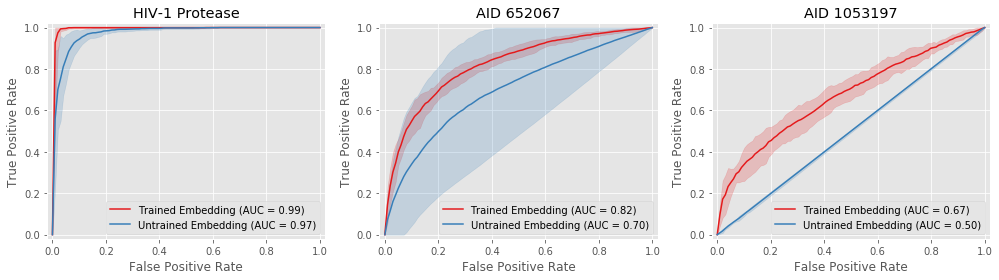

0.9971403962101636 0.003524335175656271
0.9742721791559003 0.006981712323884425
0.8201234993096884 0.012760672628385036
0.6975959322646484 0.10275752885030509
0.6718014705882354 0.016866273245640436
0.4999923406862745 0.0031683462016273527


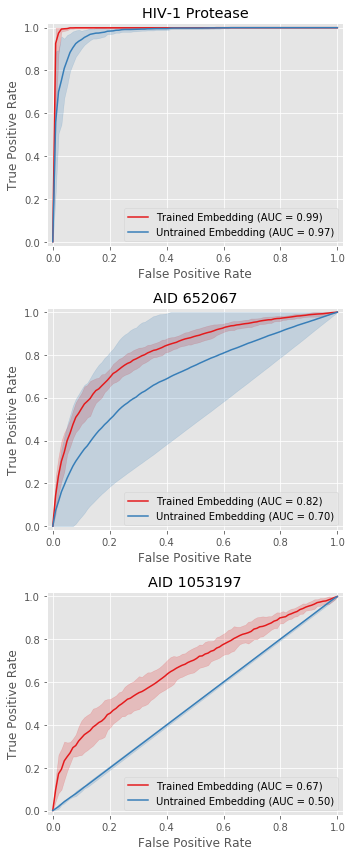

In [39]:
#matplotlib plotting code

cmap = plt.get_cmap('Set1')
sigma = 2
for layout in ["horiz", "vert"]:
    plt.rcParams["figure.figsize"] = (14, 4) if layout == "horiz" else (5, 12)
    
    if layout == "horiz":
        fig, ax = plt.subplots(ncols=3)
    else:
        fig, ax = plt.subplots(nrows=3)
    for dataset in range(3):
        for method in range(2):
            aucs, tprs = [], []
            mean_fpr = np.linspace(0, 1, 100)
            for fold in range(10):
                labs = dataset_labs[dataset][method,fold]
                preds = dataset_preds[dataset][method,fold]
                fpr, tpr, thresholds = roc_curve(labs, preds)
                interp_tpr = interp(mean_fpr, fpr, tpr)
                interp_tpr[0] = 0.0
                tprs.append(interp_tpr)
                aucs.append(roc_auc_score(labs, preds))
                #plt.plot(fpr, tpr, c=cmap(method))

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)
            ax[dataset].set_xlabel("False Positive Rate")
            ax[dataset].set_ylabel("True Positive Rate")
            ax[dataset].plot(mean_fpr, mean_tpr, c=cmap(method), 
                             label=method_names[method] + " (AUC = %0.2f)" % (mean_auc))

            std_tpr = np.std(tprs, axis=0) * sigma
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

            ax[dataset].fill_between(mean_fpr, tprs_lower, tprs_upper, 
                            color=cmap(method), alpha=0.2)
            ax[dataset].legend(loc='lower right')
            ax[dataset].set(xlim=[-.02,1.02], ylim=[-.02, 1.02])
            ax[dataset].set_title(result_names[dataset])

            aucs = np.array(aucs)
            print(aucs.mean(), aucs.std())

    plt.tight_layout()
    #plt.gcf().subplots_adjust(bottom=0.15)
    #plt.savefig('result_figures/roc_auc_revised_' + layout + '.png', dpi=300)
    plt.show()